# Repasse cambial

### Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels as st
from dateutil.relativedelta import relativedelta
import datetime
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
#removendo warnings
import warnings
warnings.filterwarnings("ignore")

### Importando e limpando os dados

In [3]:
df = pd.read_csv('dadosiccsv.csv', sep = ';')

In [4]:
#formato datetima no dataframe
inicio_date = datetime.date(1999, 1, 1)
fim_date = datetime.date(2021, 12, 1)
delta = relativedelta(months=1)
datas = []
while (inicio_date <= fim_date):
    datas.append(inicio_date)
    inicio_date += delta
for registro in range(len(df)):
    df.loc[registro, 'datetime'] = datas[registro]

In [5]:
df = df.set_index('datetime')
df1 = df.drop(columns=['Data'])

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 1999-01-01 to 2021-12-01
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Exp                      276 non-null    int64  
 1   Imp                      276 non-null    int64  
 2   PIB Mensal               276 non-null    object 
 3   Coeficiente de abertura  276 non-null    object 
 4   IPCA                     276 non-null    object 
 5   IPCA alimentos (var)     276 non-null    object 
 6   Petróleo                 276 non-null    float64
 7   Taxa de câmbio           276 non-null    object 
 8   Food price index         276 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 21.6+ KB


In [7]:
df1['PIB Mensal'] = df1['PIB Mensal'].str.replace(',', '.').astype(float)
df1['Coeficiente de abertura'] = df1['Coeficiente de abertura'].str.replace(',', '.').astype(float)
df1['Taxa de câmbio'] = df1['Taxa de câmbio'].str.replace(',', '.').astype(float)
df1['IPCA alimentos (var)'] = df1['IPCA alimentos (var)'].str.replace(',', '.').astype(float)
df1['IPCA'] = df1['IPCA'].str.replace('.', '').replace(',', '.')
df1['IPCA'] = df1['IPCA'].str.replace(',', '.').astype(float)
df1['Food price index'] = df1['Food price index'].str.replace(',', '.').astype(float)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 1999-01-01 to 2021-12-01
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Exp                      276 non-null    int64  
 1   Imp                      276 non-null    int64  
 2   PIB Mensal               276 non-null    float64
 3   Coeficiente de abertura  276 non-null    float64
 4   IPCA                     276 non-null    float64
 5   IPCA alimentos (var)     276 non-null    float64
 6   Petróleo                 276 non-null    float64
 7   Taxa de câmbio           276 non-null    float64
 8   Food price index         276 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 21.6+ KB


### Transformando valores em log natural

<br>
Transformando as variáveis: PIB Mensal, Coeficiente de abertura, IPCA, Petróleo e Taxa de câmbio.
<br>
Variáveis removidas: Exp, Imp.
<br>
Variáveis que não serão transformadas: IPCA alimentos (var).
<br>

In [9]:
df1.columns

Index(['Exp', 'Imp', 'PIB Mensal', 'Coeficiente de abertura', 'IPCA',
       'IPCA alimentos (var)', 'Petróleo', 'Taxa de câmbio',
       'Food price index'],
      dtype='object')

In [10]:
colunas_log = df1.columns.tolist()
colunas_log.remove('Exp')
colunas_log.remove('Imp')
colunas_log.remove('IPCA alimentos (var)')

In [11]:
df_log = pd.DataFrame()
for col in colunas_log:
    df_log[col] = np.log(df1[col])

In [12]:
df_log = df_log.rename(columns = {'PIB Mensal': 'PIB Mensal log', 'Coeficiente de abertura': 'Coef abertura log', 'IPCA': 'IPCA log', 'Petróleo': 'Petróleo log', 'Taxa de câmbio': 'Taxa de câmbio log', 'Food price index': 'Food price index log'})

In [13]:
df_log

,PIB Mensal log,Coef abertura log,IPCA log,Petróleo log,Taxa de câmbio log,Food price index log
datetime,,,,,,
1999-01-01,24.557349,-1.932890,7.291935,2.527327,0.684308,4.168679
1999-02-01,24.538425,-1.943374,7.302382,2.485740,0.724646,4.089834
1999-03-01,24.636868,-1.839119,7.313320,2.686486,0.543022,4.059408
1999-04-01,24.618448,-1.885727,7.318904,2.851284,0.506757,4.080415
1999-05-01,24.626510,-1.756809,7.321903,2.874694,0.544183,4.089834
...,...,...,...,...,...,...
2021-08-01,25.672026,-1.101900,8.678640,4.215086,1.637578,4.879235
2021-09-01,25.657740,-1.141217,8.690173,4.271793,1.693558,4.844659
2021-10-01,25.621106,-1.136735,8.702595,4.400358,1.730310,4.852108


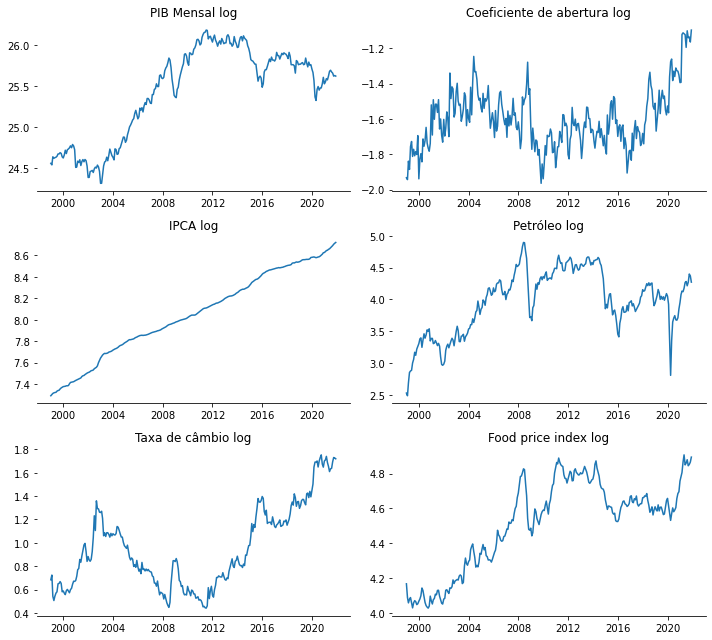

In [14]:
fig, axes = plt.subplots(3, 2, figsize = (10, 9))
axes[0,0].plot(df_log['PIB Mensal log'])
axes[0, 0].set_title('PIB Mensal log')
axes[0,1].plot(df_log['Coef abertura log'])
axes[0,1].set_title('Coeficiente de abertura log')
axes[1,0].plot(df_log['IPCA log'])
axes[1,0].set_title('IPCA log')
axes[1,1].plot(df_log['Petróleo log'])
axes[1,1].set_title('Petróleo log')
axes[2,0].plot(df_log['Taxa de câmbio log'])
axes[2,0].set_title('Taxa de câmbio log')
axes[2,1].plot(df_log['Food price index log'])
axes[2,1].set_title('Food price index log')
sns.despine(left=True)
fig.tight_layout()
plt.show()

### Transformando IPCA em variação

In [15]:
variacao_ipca = pd.DataFrame()
variacao_ipca['variação IPCA (%)'] = df_log['IPCA log'].diff() * 100

In [16]:
variacao_ipca

,variação IPCA (%)
datetime,
1999-01-01,NaN
1999-02-01,1.044640
1999-03-01,1.093852
1999-04-01,0.558382
1999-05-01,0.299838
...,...
2021-08-01,0.866225
2021-09-01,1.153287
2021-10-01,1.242208


In [17]:
#teste ADF para a série (1ª diferença)
adf_ipcavar = adfuller(variacao_ipca.dropna())[1]
if adf_ipcavar > 0.05:
    print('aceita-se H0 ADF')
else:
    print('rejeita-se H0 ADF')

rejeita-se H0 ADF


In [18]:
#teste KPSS para a série
kpss_ipcavar = kpss(variacao_ipca.dropna())[1]
if kpss_ipcavar > 0.05:
    print('aceita-se H0 KPSS')
else:
    print('rejeita-se H0 KPSS')

aceita-se H0 KPSS


In [19]:
adfuller(variacao_ipca.dropna())

(-3.699245196359161,
 0.004123783662767292,
 8,
 266,
 {'1%': -3.455175292841607,
  '5%': -2.8724677563219485,
  '10%': -2.57259315846006},
 114.67153245567243)

In [20]:
kpss(variacao_ipca.dropna())

(0.2749641116596981,
 0.1,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Filtro HP no PIB mensal

In [21]:
hp_filter = sm.tsa.filters.hpfilter(df_log[['PIB Mensal log']], 129600)

In [22]:
dfhp_filter = pd.DataFrame(hp_filter).transpose()
dfhp_filter = dfhp_filter.rename(columns = {'cycle': 'ciclo hp PIB', 'trend': 'tendência hp PIB'})

In [23]:
dfhp_filter

,ciclo hp PIB,tendência hp PIB
datetime,,
1999-01-01,-0.042501,24.599850
1999-02-01,-0.060186,24.598611
1999-03-01,0.039495,24.597372
1999-04-01,0.022316,24.596132
1999-05-01,0.031620,24.594890
...,...,...
2021-08-01,0.095609,25.576417
2021-09-01,0.085726,25.572014
2021-10-01,0.053492,25.567614


In [24]:
adfuller(dfhp_filter['ciclo hp PIB'])[1]

0.0010695617395325924

In [25]:
dfhp_filter['PIB Mensal log'] = df_log['PIB Mensal log']

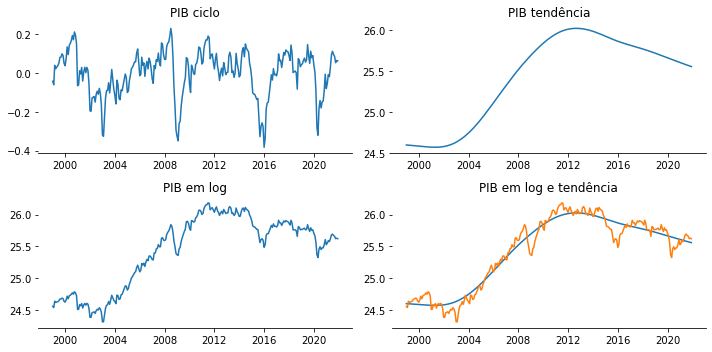

In [26]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax[0,0].plot(dfhp_filter['ciclo hp PIB'])
ax[0,0].set_title('PIB ciclo')
ax[0,1].plot(dfhp_filter['tendência hp PIB'])
ax[0,1].set_title('PIB tendência')
ax[1,0].plot(df_log['PIB Mensal log'])
ax[1,0].set_title('PIB em log')
ax[1,1].plot(dfhp_filter[['tendência hp PIB', 'PIB Mensal log']])
ax[1,1].set_title('PIB em log e tendência')
sns.despine(left=True)
fig.tight_layout()
plt.show()

### DataFrame final

In [27]:
df_final = pd.DataFrame()
df_final = df_log
df_final['variação IPCA (%)'] = variacao_ipca['variação IPCA (%)']
df_final['PIB ciclo'] = dfhp_filter['ciclo hp PIB']
df_final['PIB tendência'] = dfhp_filter['tendência hp PIB']
df_final['IPCA alimentos (%)'] = df1['IPCA alimentos (var)']

In [28]:
df_final

,PIB Mensal log,Coef abertura log,IPCA log,Petróleo log,Taxa de câmbio log,Food price index log,variação IPCA (%),PIB ciclo,PIB tendência,IPCA alimentos (%)
datetime,,,,,,,,,,
1999-01-01,24.557349,-1.932890,7.291935,2.527327,0.684308,4.168679,NaN,-0.042501,24.599850,0.90
1999-02-01,24.538425,-1.943374,7.302382,2.485740,0.724646,4.089834,1.044640,-0.060186,24.598611,2.71
1999-03-01,24.636868,-1.839119,7.313320,2.686486,0.543022,4.059408,1.093852,0.039495,24.597372,2.01
1999-04-01,24.618448,-1.885727,7.318904,2.851284,0.506757,4.080415,0.558382,0.022316,24.596132,-0.23
1999-05-01,24.626510,-1.756809,7.321903,2.874694,0.544183,4.089834,0.299838,0.031620,24.594890,-0.95
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,25.672026,-1.101900,8.678640,4.215086,1.637578,4.879235,0.866225,0.095609,25.576417,1.39
2021-09-01,25.657740,-1.141217,8.690173,4.271793,1.693558,4.844659,1.153287,0.085726,25.572014,1.02
2021-10-01,25.621106,-1.136735,8.702595,4.400358,1.730310,4.852108,1.242208,0.053492,25.567614,1.17


### Teste ADF

Hipótese nula: tem raiz unitária (não estacionário)

In [29]:
colunas = df_final.columns.tolist()
colunas.remove('variação IPCA (%)')

In [30]:
pvaloresadf = []
for i in range(len(colunas)):
    pvaloresadf.append(adfuller(df_final[colunas[i]], regression='c',)[1])

In [31]:
adf_tuples = list(zip(colunas, pvaloresadf))
adfullerteste = pd.DataFrame(adf_tuples, columns=['Série', 'p-valor'])

In [32]:
for i in range(len(adfullerteste['p-valor'])):
    if adfullerteste.loc[i, 'p-valor']>0.05:
        adfullerteste.loc[i, 'resultado'] = 'aceita-se H0 a 5%'
    else: 
        adfullerteste.loc[i, 'resultado'] = 'rejeita-se'

In [33]:
adfullerteste = adfullerteste.set_index('Série')

In [34]:
adfullerteste.iloc[3,0] = adfuller(df_final['Petróleo log'], regression = 'ct')[1]

In [35]:
adfullerteste.iloc[7,0] = adfuller(df_final['PIB tendência'], regression = 'ct')[1]

In [36]:
if adfullerteste.iloc[3,0] > 0.05:
    adfullerteste.iloc[3, 1] = 'aceita-se H0 a 5%'
else: 
    adfullerteste.iloc[3, 1] = 'rejeita-se'

In [37]:
if adfullerteste.iloc[7,0] > 0.05:
    adfullerteste.iloc[7, 1] = 'aceita-se H0 a 5%'
else: 
    adfullerteste.iloc[7, 1] = 'rejeita-se'

In [38]:
adfullerteste

,p-valor,resultado
Série,,
PIB Mensal log,5.595121e-01,aceita-se H0 a 5%
Coef abertura log,6.678858e-01,aceita-se H0 a 5%
IPCA log,8.511967e-01,aceita-se H0 a 5%
Petróleo log,1.874762e-01,aceita-se H0 a 5%
Taxa de câmbio log,8.410366e-01,aceita-se H0 a 5%
Food price index log,5.215360e-01,aceita-se H0 a 5%
PIB ciclo,1.069562e-03,rejeita-se
PIB tendência,3.292569e-01,aceita-se H0 a 5%
IPCA alimentos (%),6.103238e-14,rejeita-se


In [39]:
estatadf = []
for i in range(len(colunas)):
    estatadf.append(adfuller(df_final[colunas[i]], regression='c',)[0])
adf_tuples_1 = list(zip(colunas, estatadf))
adfullerteste_1 = pd.DataFrame(adf_tuples_1, columns=['Série', 'estatística'])
adfullerteste_1 = adfullerteste_1.set_index('Série')
adfullerteste_1.iloc[3,0] = adfuller(df_final['Petróleo log'], regression = 'ct')[0]
adfullerteste_1.iloc[7,0] = adfuller(df_final['PIB tendência'], regression = 'ct')[0]

In [40]:
adfullerteste_1

,estatística
Série,
PIB Mensal log,-1.447074
Coef abertura log,-1.213214
IPCA log,-0.682634
Petróleo log,-2.826233
Taxa de câmbio log,-0.721744
Food price index log,-1.524143
PIB ciclo,-4.073844
PIB tendência,-2.497413
IPCA alimentos (%),-8.621065


### Teste KPSS

Hipótese nula: estacionariedade

In [41]:
pvaloreskpss = []
for i in range(len(colunas)):
    pvaloreskpss.append(kpss(df_final[colunas[i]])[1])
    
kpss_tuples = list(zip(colunas, pvaloreskpss))
kpssteste = pd.DataFrame(kpss_tuples, columns=['Série', 'p-valor'])

for i in range(len(kpssteste['p-valor'])):
    if kpssteste.loc[i, 'p-valor']>0.05:
        kpssteste.loc[i, 'resultado'] = 'aceita-se H0 a 5%'
    else: 
        kpssteste.loc[i, 'resultado'] = 'rejeita-se'

In [42]:
kpssteste

,Série,p-valor,resultado
0,PIB Mensal log,0.01000,rejeita-se
1,Coef abertura log,0.05743,aceita-se H0 a 5%
2,IPCA log,0.01000,rejeita-se
3,Petróleo log,0.01000,rejeita-se
4,Taxa de câmbio log,0.01000,rejeita-se
5,Food price index log,0.01000,rejeita-se
6,PIB ciclo,0.10000,aceita-se H0 a 5%
7,PIB tendência,0.01000,rejeita-se
8,IPCA alimentos (%),0.10000,aceita-se H0 a 5%


In [43]:
kpssteste = kpssteste.set_index('Série')
kpssteste.iloc[3,0] = kpss(df1['Petróleo'], regression = 'ct')[1]
if kpssteste.iloc[3,0] > 0.05:
    kpssteste.iloc[3, 1] = 'aceita-se H0 a 5%'
else: 
    kpssteste.iloc[3, 1] = 'rejeita-se'

In [44]:
kpssteste.iloc[7,0] = kpss(df_final['PIB tendência'], regression = 'ct')[1]
if kpssteste.iloc[7,0] > 0.05:
    kpssteste.iloc[7, 1] = 'aceita-se H0 a 5%'
else: 
    kpssteste.iloc[7, 1] = 'rejeita-se'

In [45]:
kpssteste

,p-valor,resultado
Série,,
PIB Mensal log,0.01000,rejeita-se
Coef abertura log,0.05743,aceita-se H0 a 5%
IPCA log,0.01000,rejeita-se
Petróleo log,0.01000,rejeita-se
Taxa de câmbio log,0.01000,rejeita-se
Food price index log,0.01000,rejeita-se
PIB ciclo,0.10000,aceita-se H0 a 5%
PIB tendência,0.01000,rejeita-se
IPCA alimentos (%),0.10000,aceita-se H0 a 5%


In [46]:
estatkpss = []
for i in range(len(colunas)):
    estatkpss.append(kpss(df_final[colunas[i]])[0])
    
kpss_tuples_1 = list(zip(colunas, estatkpss))
kpssteste_1 = pd.DataFrame(kpss_tuples_1, columns=['Série', 'estat'])
kpssteste_1 = kpssteste_1.set_index('Série')
kpssteste_1.iloc[3,0] = kpss(df1['Petróleo'], regression = 'ct')[0]
kpssteste_1.iloc[7,0] = kpss(df_final['PIB tendência'], regression = 'ct')[0]

In [47]:
kpssteste_1

,estat
Série,
PIB Mensal log,1.859285
Coef abertura log,0.445762
IPCA log,2.585411
Petróleo log,0.466023
Taxa de câmbio log,1.213934
Food price index log,1.900114
PIB ciclo,0.055296
PIB tendência,0.598297
IPCA alimentos (%),0.045165


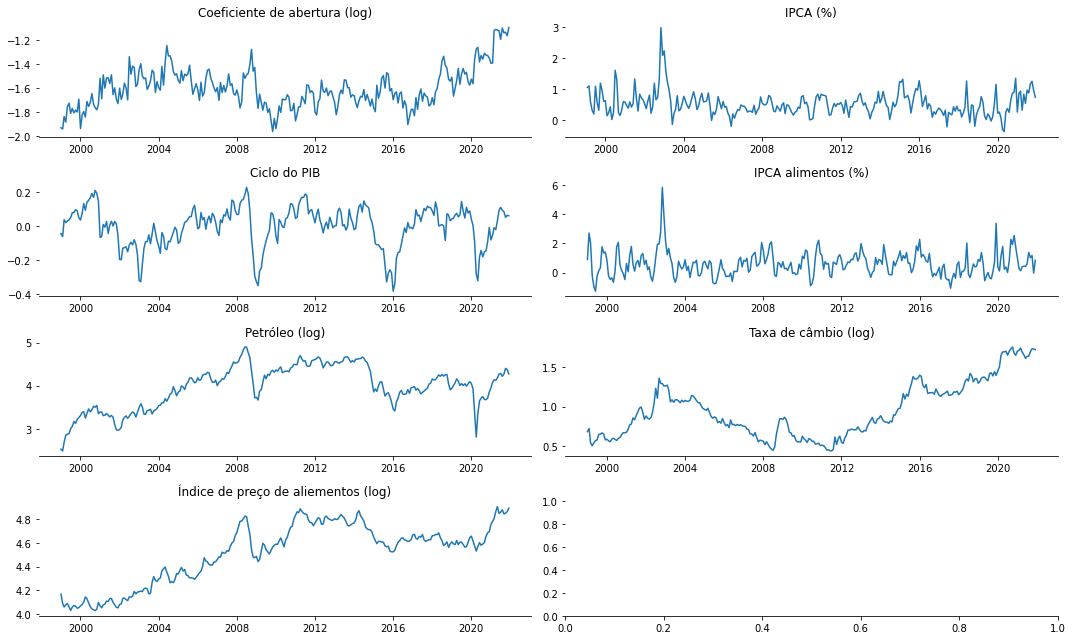

In [48]:
fig, axes = plt.subplots(4, 2, figsize = (15, 9))
axes[0,0].plot(df_final['Coef abertura log'])
axes[0,0].set_title('Coeficiente de abertura (log)')
axes[0,1].plot(df_final['variação IPCA (%)'])
axes[0,1].set_title('IPCA (%)')
axes[1,0].plot(df_final['PIB ciclo'])
axes[1,0].set_title('Ciclo do PIB')
axes[1,1].plot(df_final['IPCA alimentos (%)'])
axes[1,1].set_title('IPCA alimentos (%)')
axes[2,0].plot(df_final['Petróleo log'])
axes[2,0].set_title('Petróleo (log)')
axes[2,1].plot(df_final['Taxa de câmbio log'])
axes[2,1].set_title('Taxa de câmbio (log)')
axes[3,0].plot(df_final['Food price index log'])
axes[3,0].set_title('Índice de preço de aliementos (log)')
sns.despine(left=True)
fig.tight_layout()
plt.show()

### Diferenciação das séries

In [49]:
df_final

,PIB Mensal log,Coef abertura log,IPCA log,Petróleo log,Taxa de câmbio log,Food price index log,variação IPCA (%),PIB ciclo,PIB tendência,IPCA alimentos (%)
datetime,,,,,,,,,,
1999-01-01,24.557349,-1.932890,7.291935,2.527327,0.684308,4.168679,NaN,-0.042501,24.599850,0.90
1999-02-01,24.538425,-1.943374,7.302382,2.485740,0.724646,4.089834,1.044640,-0.060186,24.598611,2.71
1999-03-01,24.636868,-1.839119,7.313320,2.686486,0.543022,4.059408,1.093852,0.039495,24.597372,2.01
1999-04-01,24.618448,-1.885727,7.318904,2.851284,0.506757,4.080415,0.558382,0.022316,24.596132,-0.23
1999-05-01,24.626510,-1.756809,7.321903,2.874694,0.544183,4.089834,0.299838,0.031620,24.594890,-0.95
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,25.672026,-1.101900,8.678640,4.215086,1.637578,4.879235,0.866225,0.095609,25.576417,1.39
2021-09-01,25.657740,-1.141217,8.690173,4.271793,1.693558,4.844659,1.153287,0.085726,25.572014,1.02
2021-10-01,25.621106,-1.136735,8.702595,4.400358,1.730310,4.852108,1.242208,0.053492,25.567614,1.17


In [50]:
# Diferenciar: Food price index log, Taxa de câmbio log, Petróleo log
colunas_diff = ['Petróleo log', 'Taxa de câmbio log', 'Food price index log']

In [51]:
df_diff = pd.DataFrame()
for col in colunas_diff:
    df_diff[col] = df_final[col].diff()

In [52]:
df_diff = df_diff.rename(columns = {'Petróleo log': 'Petróleo log diff', 'Taxa de câmbio log': 'Taxa de câmbio log diff', 'Food price index log': 'Food price index log diff'})

In [53]:
df_diff

,Petróleo log diff,Taxa de câmbio log diff,Food price index log diff
datetime,,,
1999-01-01,NaN,NaN,NaN
1999-02-01,-0.041588,0.040338,-0.078844
1999-03-01,0.200746,-0.181624,-0.030426
1999-04-01,0.164798,-0.036264,0.021007
1999-05-01,0.023410,0.037426,0.009420
...,...,...,...
2021-08-01,-0.068362,0.004229,0.019190
2021-09-01,0.056707,0.055980,-0.034576
2021-10-01,0.128564,0.036751,0.007449


In [54]:
#teste KPSS para as diferenças
colunas_diff2 = df_diff.columns.tolist()
pvaloreskpss2 = []
for i in range(len(colunas_diff2)):
    pvaloreskpss2.append(kpss(df_diff[colunas_diff2[i]].dropna())[1])
    
kpss_tuples2 = list(zip(colunas_diff2, pvaloreskpss2))
kpssteste2 = pd.DataFrame(kpss_tuples2, columns=['Série', 'p-valor'])

for i in range(len(kpssteste2['p-valor'])):
    if kpssteste2.loc[i, 'p-valor']>0.05:
        kpssteste2.loc[i, 'resultado'] = 'aceita-se H0 a 5%'
    else: 
        kpssteste2.loc[i, 'resultado'] = 'rejeita-se'

In [55]:
kpssteste2

,Série,p-valor,resultado
0,Petróleo log diff,0.1,aceita-se H0 a 5%
1,Taxa de câmbio log diff,0.1,aceita-se H0 a 5%
2,Food price index log diff,0.1,aceita-se H0 a 5%


In [56]:
df_final['Petróleo log diff'] = df_diff['Petróleo log diff']
df_final['Taxa de câmbio log diff'] = df_diff['Taxa de câmbio log diff']
df_final['Food price index log diff'] = df_diff['Food price index log diff']

In [58]:
df_final = df_final.dropna()

In [59]:
df_final

,PIB Mensal log,Coef abertura log,IPCA log,Petróleo log,Taxa de câmbio log,Food price index log,variação IPCA (%),PIB ciclo,PIB tendência,IPCA alimentos (%),Petróleo log diff,Taxa de câmbio log diff,Food price index log diff
datetime,,,,,,,,,,,,,
1999-02-01,24.538425,-1.943374,7.302382,2.485740,0.724646,4.089834,1.044640,-0.060186,24.598611,2.71,-0.041588,0.040338,-0.078844
1999-03-01,24.636868,-1.839119,7.313320,2.686486,0.543022,4.059408,1.093852,0.039495,24.597372,2.01,0.200746,-0.181624,-0.030426
1999-04-01,24.618448,-1.885727,7.318904,2.851284,0.506757,4.080415,0.558382,0.022316,24.596132,-0.23,0.164798,-0.036264,0.021007
1999-05-01,24.626510,-1.756809,7.321903,2.874694,0.544183,4.089834,0.299838,0.031620,24.594890,-0.95,0.023410,0.037426,0.009420
1999-06-01,24.631542,-1.727859,7.323798,2.885917,0.570245,4.059926,0.189500,0.037895,24.593646,-1.28,0.011223,0.026062,-0.029909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,25.672026,-1.101900,8.678640,4.215086,1.637578,4.879235,0.866225,0.095609,25.576417,1.39,-0.068362,0.004229,0.019190
2021-09-01,25.657740,-1.141217,8.690173,4.271793,1.693558,4.844659,1.153287,0.085726,25.572014,1.02,0.056707,0.055980,-0.034576
2021-10-01,25.621106,-1.136735,8.702595,4.400358,1.730310,4.852108,1.242208,0.053492,25.567614,1.17,0.128564,0.036751,0.007449


In [60]:
data = df_final.drop(columns = ['PIB Mensal log', 'IPCA log', 'Petróleo log', 'Taxa de câmbio log', 'Food price index log'])

In [61]:
#fica apenas o ciclo como proxy da demanda
data = data.drop(columns = ['PIB tendência'])

In [62]:
data

,Coef abertura log,variação IPCA (%),PIB ciclo,IPCA alimentos (%),Petróleo log diff,Taxa de câmbio log diff,Food price index log diff
datetime,,,,,,,
1999-02-01,-1.943374,1.044640,-0.060186,2.71,-0.041588,0.040338,-0.078844
1999-03-01,-1.839119,1.093852,0.039495,2.01,0.200746,-0.181624,-0.030426
1999-04-01,-1.885727,0.558382,0.022316,-0.23,0.164798,-0.036264,0.021007
1999-05-01,-1.756809,0.299838,0.031620,-0.95,0.023410,0.037426,0.009420
1999-06-01,-1.727859,0.189500,0.037895,-1.28,0.011223,0.026062,-0.029909
...,...,...,...,...,...,...,...
2021-08-01,-1.101900,0.866225,0.095609,1.39,-0.068362,0.004229,0.019190
2021-09-01,-1.141217,1.153287,0.085726,1.02,0.056707,0.055980,-0.034576
2021-10-01,-1.136735,1.242208,0.053492,1.17,0.128564,0.036751,0.007449


In [63]:
#teste ADF para as diferenças
colunas_diff2 = df_diff.columns.tolist()
pvaloresadf2 = []
for i in range(len(colunas_diff2)):
    pvaloresadf2.append(adfuller(df_diff[colunas_diff2[i]].dropna())[1])
    
adf_tuples2 = list(zip(colunas_diff2, pvaloresadf2))
adfteste2 = pd.DataFrame(adf_tuples2, columns=['Série', 'p-valor'])

for i in range(len(adfteste2['p-valor'])):
    if adfteste2.loc[i, 'p-valor']>0.05:
        adfteste2.loc[i, 'resultado'] = 'aceita-se H0 a 5%'
    else: 
        adfteste2.loc[i, 'resultado'] = 'rejeita-se'

In [64]:
adfteste2.iloc[2,1]

4.041004062859541e-22

In [65]:
adfteste2

,Série,p-valor,resultado
0,Petróleo log diff,1.326354e-20,rejeita-se
1,Taxa de câmbio log diff,1.903846e-18,rejeita-se
2,Food price index log diff,4.041004e-22,rejeita-se


In [66]:
#teste KPSS para as diferenças (estat)
colunas_diff2 = df_diff.columns.tolist()
estatkpss2 = []
for i in range(len(colunas_diff2)):
    estatkpss2.append(kpss(df_diff[colunas_diff2[i]].dropna())[0])
    
kpss_tuples2_1 = list(zip(colunas_diff2, estatkpss2))
kpssteste2_1 = pd.DataFrame(kpss_tuples2, columns=['Série', 'estat'])

In [67]:
kpss(df_diff[['Petróleo log diff']].dropna())

(0.1452566676207729,
 0.1,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [68]:
kpss(df_diff[['Taxa de câmbio log diff']].dropna())

(0.18262292909921995,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [69]:
kpss(df_diff[['Food price index log diff']].dropna())

(0.061584607588604984,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [70]:
adfuller(df_diff[['Petróleo log diff']].dropna())

(-11.298354487573198,
 1.3263536719482001e-20,
 1,
 273,
 {'1%': -3.45453261164607,
  '5%': -2.8721859575020017,
  '10%': -2.572442854861866},
 -446.9178875939904)

In [71]:
adfuller(df_diff[['Taxa de câmbio log diff']].dropna())

(-10.40153197302534,
 1.9038457951388928e-18,
 1,
 273,
 {'1%': -3.45453261164607,
  '5%': -2.8721859575020017,
  '10%': -2.572442854861866},
 -815.3596725707976)

In [72]:
adfuller(df_diff[['Food price index log diff']].dropna())

(-11.963964759326293,
 4.041004062859541e-22,
 0,
 274,
 {'1%': -3.4544435065994437,
  '5%': -2.8721468827772774,
  '10%': -2.572422013959188},
 -1109.4551153049506)

### Teste de Causalidade de Granger

hipótese nula: não-granger-causa
<br> 
The data for testing whether the time series in the second column Granger causes the time series in the first column. Missing values are not supported.

o segundo causando o primeiro

In [73]:
data.columns

Index(['Coef abertura log', 'variação IPCA (%)', 'PIB ciclo',
       'IPCA alimentos (%)', 'Petróleo log diff', 'Taxa de câmbio log diff',
       'Food price index log diff'],
      dtype='object')

In [74]:
from statsmodels.tsa.stattools import grangercausalitytests

In [124]:
maxlag=4
test = 'ssr_ftest'

def grangers_causation_matrix(data, variables, test='ssr_ftest', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [125]:
#coluna causando linha
grangers_causation_matrix(data, variables = data.columns)

,Coef abertura log_x,variação IPCA (%)_x,PIB ciclo_x,IPCA alimentos (%)_x,Petróleo log diff_x,Taxa de câmbio log diff_x,Food price index log diff_x
Coef abertura log_y,1.0000,0.0520,0.0544,0.0386,0.1419,0.0034,0.0001
variação IPCA (%)_y,0.0071,1.0000,0.0672,0.0559,0.1307,0.0000,0.5079
PIB ciclo_y,0.0002,0.1257,1.0000,0.0314,0.0000,0.0000,0.0026
IPCA alimentos (%)_y,0.1531,0.1774,0.2732,1.0000,0.4331,0.0002,0.1786
Petróleo log diff_y,0.4887,0.3033,0.0229,0.0459,1.0000,0.0093,0.0012
Taxa de câmbio log diff_y,0.1328,0.0551,0.0033,0.0356,0.0266,1.0000,0.0114
Food price index log diff_y,0.0016,0.5519,0.0279,0.2868,0.3165,0.0379,1.0000


In [126]:
maxlag=4
test = 'ssr_ftest'

def grangers_causation_matrix2(data, variables, test='ssr_ftest', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[c, r]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {c}, X = {r}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[c, r] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [127]:
grangers_causation_matrix2(data, variables = data.columns)

,Coef abertura log_x,variação IPCA (%)_x,PIB ciclo_x,IPCA alimentos (%)_x,Petróleo log diff_x,Taxa de câmbio log diff_x,Food price index log diff_x
Coef abertura log_y,1.0000,0.0520,0.0544,0.0386,0.1419,0.0034,0.0001
variação IPCA (%)_y,0.0071,1.0000,0.0672,0.0559,0.1307,0.0000,0.5079
PIB ciclo_y,0.0002,0.1257,1.0000,0.0314,0.0000,0.0000,0.0026
IPCA alimentos (%)_y,0.1531,0.1774,0.2732,1.0000,0.4331,0.0002,0.1786
Petróleo log diff_y,0.4887,0.3033,0.0229,0.0459,1.0000,0.0093,0.0012
Taxa de câmbio log diff_y,0.1328,0.0551,0.0033,0.0356,0.0266,1.0000,0.0114
Food price index log diff_y,0.0016,0.5519,0.0279,0.2868,0.3165,0.0379,1.0000


### Defasagem

In [128]:
from statsmodels.tsa.api import VAR

In [129]:
model = VAR(data)

In [130]:
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('BIC : ', result.bic, '\n')

Lag Order = 1
BIC :  -32.10204866267386 

Lag Order = 2
BIC :  -31.66614340840051 

Lag Order = 3
BIC :  -31.026689489741067 

Lag Order = 4
BIC :  -30.441924655362957 

Lag Order = 5
BIC :  -29.734285704273944 

Lag Order = 6
BIC :  -29.175070885933224 

Lag Order = 7
BIC :  -28.407538939501 

Lag Order = 8
BIC :  -27.659960208961124 

Lag Order = 9
BIC :  -26.938188479797574 



In [131]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-28.77,-28.67,3.211e-13,-28.73
1,-32.93,-32.17*,5.010e-15,-32.62*
2,-33.04,-31.61,4.502e-15,-32.46
3,-33.06,-30.97,4.410e-15,-32.22
4,-33.16,-30.40,3.999e-15*,-32.05
5,-33.13,-29.70,4.155e-15,-31.75
6,-33.17*,-29.08,4.027e-15,-31.52
7,-33.07,-28.32,4.491e-15,-31.16
8,-33.02,-27.60,4.786e-15,-30.84
9,-32.98,-26.90,5.078e-15,-30.54


In [132]:
model_fitted = model.fit(4)

In [133]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Aug, 2022
Time:                     20:13:52
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -30.4419
Nobs:                     271.000    HQIC:                  -32.0568
Log likelihood:           2001.77    FPE:                4.07285e-15
AIC:                     -33.1402    Det(Omega_mle):     1.99910e-15
--------------------------------------------------------------------
Results for equation Coef abertura log
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               -0.148624         0.053502           -2.778           0.005
L1.Coef abertura log                 0.544166         0.063937            8.511     

### Teste de autocorrelação Ljung-Box

Hipótese nula: sem autocorrelação

In [134]:
import statsmodels.api as sm

In [135]:
data

,Coef abertura log,variação IPCA (%),PIB ciclo,IPCA alimentos (%),Petróleo log diff,Taxa de câmbio log diff,Food price index log diff
datetime,,,,,,,
1999-02-01,-1.943374,1.044640,-0.060186,2.71,-0.041588,0.040338,-0.078844
1999-03-01,-1.839119,1.093852,0.039495,2.01,0.200746,-0.181624,-0.030426
1999-04-01,-1.885727,0.558382,0.022316,-0.23,0.164798,-0.036264,0.021007
1999-05-01,-1.756809,0.299838,0.031620,-0.95,0.023410,0.037426,0.009420
1999-06-01,-1.727859,0.189500,0.037895,-1.28,0.011223,0.026062,-0.029909
...,...,...,...,...,...,...,...
2021-08-01,-1.101900,0.866225,0.095609,1.39,-0.068362,0.004229,0.019190
2021-09-01,-1.141217,1.153287,0.085726,1.02,0.056707,0.055980,-0.034576
2021-10-01,-1.136735,1.242208,0.053492,1.17,0.128564,0.036751,0.007449


In [ ]:
autocorr = pd.DataFrame()
for x in data.columns():
    res = sm.tsa.ARMA()